In [2]:
import os
import sys
import random
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import tensorflow as tf

## Load Image

In [5]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
directory = os.getcwd()
DATA_DIR = os.path.abspath("../data")
TRAIN_PATH = os.path.join(DATA_DIR, 'stage1_train') + '/'
TEST_PATH = os.path.join(DATA_DIR, 'stage1_test') + '/'
INPUT_PATH = os.path.join(directory, 'input')

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [6]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [8]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:05<00:00,  5.35it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 60.53it/s]


Done!


c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


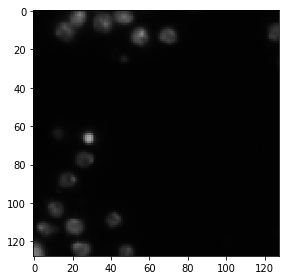

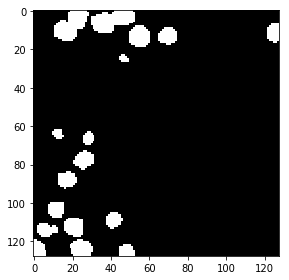

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\wstra\.virtualenvs\nuclei-vxu5rk9n\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


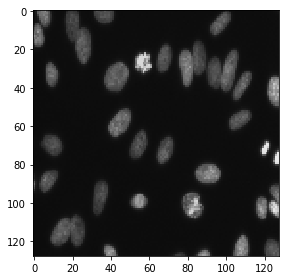

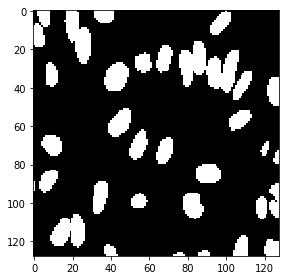

NameError: name 'iaa' is not defined

In [10]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

seq = iaa.Sequential([iaa.Sometimes(.8, iaa.Affine(rotate=45,
                                                       mode='reflect')),
                          iaa.Fliplr(p=.25)
                          ],
                         random_order=False)
test = seq.augment_images(X_train[ix])
imshow(test)
plt.show()

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [13]:
from threading import Lock
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """

    def __init__(self, it):
        self.it = it
        self.lock = Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

In [14]:
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """

    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))

    return g

In [43]:
# have to restart kernel to get code changes, better off pasting here and then to file
import data_aug
aug = data_aug.get_augmentor()

augmentor = [iaa.SomeOf((0, None), [iaa.Fliplr(0.5),
                                   iaa.Flipud(0.5),
                                  ])]

#TODO: fix cropping
augmentor = [iaa.SomeOf((0, None), [iaa.Fliplr(0.5),
                                    iaa.Flipud(0.5),
#                                     iaa.CropAndPad(  # randomly crop up to 10 percent
#                                         percent=(0, 0.1),
#                                         pad_mode=["constant", "edge"],  # use constant value or closest edge pixel
#                                         pad_cval=(0, 256)
#                                     ), 
                                    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
                                    iaa.Affine(translate_px={"x": (-15, 15), "y": (-15, 15)}),
                                    iaa.Affine(rotate=(-45, 45)),
                                    iaa.Affine(shear=(-20, 20)),
                                    iaa.Multiply((0.5, 1.5), per_channel=0.5),  # lighten or darken
                                    iaa.GaussianBlur(sigma=(0.0, 2.0)),
                                  ])]
                    

In [30]:
import imgaug as ia
from imgaug import augmenters as iaa
@threadsafe_generator
def double_batch_generator(images, labels, batch_size):
    seq = iaa.Sequential(augmentor,
                         random_order=True)
    seq_copy = seq.deepcopy()
    
    aug_seed = 0
    while True:
        x_batch, y_batch = form_double_batch(images, labels, batch_size)
        seq.reseed(aug_seed)
        seq_copy.reseed(aug_seed)
        new_x_batch = seq.augment_images(x_batch)
        new_y_batch = seq_copy.augment_images(y_batch)
        new_x_batch = np.array(new_x_batch).astype('float16')
        new_y_batch = np.array(new_y_batch).astype('float16')
      #  yield x_batch, y_batch
        aug_seed+=1
        yield new_x_batch, new_y_batch

In [17]:
def form_double_batch(x, y, batch_size):
    idx = np.random.randint(0, x.shape[0], int(batch_size))
    return x[idx], y[idx]

In [18]:
def make_double_generator(batch_size=15):
        return double_batch_generator(X_train, Y_train, batch_size)

In [44]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1) #monitor='mean_iou'
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(make_double_generator(32), epochs=30, steps_per_epoch=10, 
                              validation_data=make_double_generator(32),
                              validation_steps=10,
                              workers=4,
                              callbacks=[earlystopper, checkpointer])

#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
#                    callbacks=[earlystopper, checkpointer])

Epoch 1/30
10/10 [==============================] - 29s 3s/step - loss: 0.1848 - mean_iou: 0.4121 - val_loss: 0.1633 - val_mean_iou: 0.4144

Epoch 00001: val_loss improved from inf to 0.16327, saving model to model-dsbowl2018-1.h5
Epoch 2/30
10/10 [==============================] - 28s 3s/step - loss: 0.1758 - mean_iou: 0.4163 - val_loss: 0.1945 - val_mean_iou: 0.4182

Epoch 00002: val_loss did not improve
Epoch 3/30
 3/10 [========>.....................] - ETA: 13s - loss: 0.1872 - mean_iou: 0.4192

KeyboardInterrupt: 

In [ ]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()